In [1]:
import zipfile
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt

True


In [4]:
info_estaciones = pd.read_excel('C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/AirQuality/informacion_estaciones_red_calidad_aire(1).xls', engine = 'xlrd')
info_estaciones = info_estaciones[['CODIGO', 'CODIGO_CORTO', 'LONGITUD', 'LATITUD']]
info_estaciones = info_estaciones.drop(columns=['CODIGO'])
info_estaciones

,CODIGO_CORTO,LONGITUD,LATITUD
0,4,-3.712257,40.423882
1,8,-3.682316,40.421553
2,11,-3.677349,40.451473
3,16,-3.639242,40.440046
4,17,-3.713317,40.347147
5,18,-3.731836,40.394782
6,24,-3.747345,40.419358
7,27,-3.580026,40.476918
8,35,-3.703166,40.419209
9,36,-3.645310,40.407952


---

In [12]:
import zipfile
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
print(os.path.exists('Files/Exposome_ds_UC3M/Database/Calidad del aire/Anio202312.zip'))

import time


import os
import json
import pandas as pd

def extract_coordinates(location, fallback=None):
    """Extract latitude and longitude from the location object with a fallback."""
    lat = location.get('latitudeE7')
    lon = location.get('longitudeE7')
    if lat is None or lon is None:  # Use fallback if necessary
        if fallback and 'waypoints' in fallback:
            lat = fallback['waypoints'][0].get('latE7')
            lon = fallback['waypoints'][0].get('lngE7')
    return (lat / 1e7 if lat else None, lon / 1e7 if lon else None)

def filter_by_bounding_box(df, lat_min = 40.3, lat_max = 40.6, lon_min=-3.8, lon_max=-3.6):
    """Filters rows by latitude and longitude bounding box."""
    return df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
              (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

def process_json_files(folder_path):
    # Initialize a list to hold all rows of extracted data
    rows = []

    # Walk through the folder and subfolders to read JSON files
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.json'):  # Check for JSON files
                file_path = os.path.join(root, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                        for item in data.get('timelineObjects', []):
                            if 'activitySegment' in item:
                                activity = item['activitySegment']

                                # Extract coordinates (with fallback to waypointPath)
                                start_location = activity.get('startLocation', {})
                                end_location = activity.get('endLocation', {})
                                waypoints = activity.get('waypointPath', {})

                                start_lat, start_lon = extract_coordinates(start_location, waypoints)
                                end_lat, end_lon = extract_coordinates(end_location, waypoints)

                                # Extract timestamps
                                start_timestamp = activity.get('duration', {}).get('startTimestamp')
                                end_timestamp = activity.get('duration', {}).get('endTimestamp')

                                # Create a row with relevant data
                                row = {
                                    'file_name': file_name,
                                    'start_timestamp': start_timestamp,
                                    'end_timestamp': end_timestamp,
                                    'start_latitude': start_lat,
                                    'start_longitude': start_lon,
                                    'end_latitude': end_lat,
                                    'end_longitude': end_lon,
                                    'address': None  # No address in activitySegment
                                }
                                rows.append(row)

                            elif 'placeVisit' in item:
                                place = item['placeVisit']

                                # Extract visit location data
                                location = place['location']
                                latitude = location.get('latitudeE7') / 1e7
                                longitude = location.get('longitudeE7') / 1e7
                                address = location.get('address')

                                # Extract timestamps
                                start_timestamp = place.get('duration', {}).get('startTimestamp')
                                end_timestamp = place.get('duration', {}).get('endTimestamp')

                                # Create a row with relevant data
                                row = {
                                    'file_name': file_name,
                                    'start_timestamp': start_timestamp,
                                    'end_timestamp': end_timestamp,
                                    'start_latitude': latitude,
                                    'start_longitude': longitude,
                                    'end_latitude': None,
                                    'end_longitude': None,
                                    'address': address
                                }
                                rows.append(row)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    # Create a DataFrame from the extracted rows
    df = pd.DataFrame(rows)

    # Preprocessing:
    # Dropping unnecessary columns
    df = df.drop(columns=['end_latitude', 'end_longitude', 'end_timestamp'])

    # Renaming columns for general use
    df = df.rename(columns={'start_latitude': 'latitude', 'start_longitude': 'longitude'})

    # Dropping rows with NA in latitude or longitude
    df = df.dropna(subset=['latitude', 'longitude'])

    

    return df




"""

Preprocessing pipeline:

1. Only get the rows that are in Madrid
2. Convert the timestamp to be rounded to the nearest minute (to be compatible with the air quality data)
    2.1 Remove any duplicates in the timestamp (we round so we dont care about being in two places at once)

3. Make sure it is compatible with the air quality data


"""


def preprocessing_timeline(df:pd.DataFrame):


    """
    Input: 'df' type: pd.DataFrame

    output: 'df' type: pd.Dataframe

    Preprocessing pipeline:

    1. Only get the rows that are in Madrid
    2. Convert the timestamp to be rounded to the nearest minute (to be compatible with the air quality data)
        2.1 Remove any duplicates in the timestamp (we round so we dont care about being in two places at once)

    3. Make sure it is compatible with the air quality data
    
    """

# 1. Only getting the rows that are in Madrid
    df = filter_by_bounding_box(df)

# 2. Convert the time stamp to be rounded to the nearest minute and remove duplicates

    # Convert start_timestamp to datetime
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='mixed')


    # Round to the nearest minute
    df['start_timestamp'] = df['start_timestamp'].dt.round('min')

    # removing the duplicates rows that result from rounding to the nearest minute.
    df = df.drop_duplicates(subset=['start_timestamp'])

    # 3. Make sure it is compatible with the Air quality data
    # CHANGE THE NAME HERE
    df = df.rename(columns={'start_timestamp':'timestamp'})


    return df


def full_timeline_data(folder_path):

    df = process_json_files(folder_path)

    timeline = preprocessing_timeline(df)

    return timeline



def get_years(df:pd.DataFrame):

    years = df['timestamp'].dt.year.unique()


    return years

def get_months(years:list, df: pd.DataFrame):

    months = []
    for i in range(len(years)):

        temp_df = df[df['timestamp'].dt.year == years[i]]

        # Getting the unique months here:

        

        month = temp_df['timestamp'].dt.month.unique()
        months.append(month)

    return months







"""
----------------------------------------------------------------------------------------------------


NOTE: THIS BELOW IS ONLY FOR AIR QUALITY

Air Quality Dataset reading and preprocessing:


----------------------------------------------------------------------------------------------------

"""

import os
import zipfile
import pandas as pd
import re

def extract_air_quality_data(directory, years):
    """
    Extract air quality data from ZIP files for specified years.
    
    Args:
        directory (str): Path to the directory containing ZIP files.
        years (list): List of years (as integers or strings) to filter files.

    Returns:
        pd.DataFrame: Combined data from the specified years.
    """
    # Convert years to strings for comparison
    years = set(map(str, years))
    
    # Initialize an empty DataFrame
    combined_data = pd.DataFrame()

    # Loop through files in the directory
    for file in os.listdir(directory):
        # Check if the file is a ZIP file
        if file.endswith(".zip"):
            # Extract the year from the filename using regex
            match = re.search(r'Anio(\d{4})', file)
            if match:
                file_year = match.group(1)
                # Process only if the year is in the provided list
                if file_year in years:
                    zip_path = os.path.join(directory, file)
                    print(f"Processing file: {file}")
                    # Open the ZIP file
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        # List all files in the ZIP archive
                        for inner_file in zip_ref.namelist():
                            # Check if the file is a CSV
                            if inner_file.endswith(".csv"):
                                # Read the CSV file directly from the ZIP
                                with zip_ref.open(inner_file) as csv_file:
                                    df = pd.read_csv(csv_file, sep=';')
                                    
                                    # Optionally, ensure timestamps are in datetime format
                                    if 'timestamp' in df.columns:
                                        df['timestamp'] = pd.to_datetime(df['timestamp'])
                                    
                                    # Append to the combined DataFrame
                                    combined_data = pd.concat([combined_data, df], ignore_index=True)
    
    return combined_data

# Usage example
# directory_path = "C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/Exposome_ds_UC3M/Database/Calidad del aire"
# years_to_process = get_years(timeline)  # Specify the years to process
# result_df = extract_air_quality_data(directory_path, years_to_process)

def get_relevant_AQ(timeline:pd.DataFrame, result_df:pd.DataFrame):

    # timeline == the data from the time line google takeout
    # result_df == the data from the extract_air_quality_data



    years_to_process = get_years(timeline) # Specify the years to process
    months_to_process = get_months(years_to_process, timeline)

    df_collection = []

    for year in range(0,len(years_to_process)):
        temp_df = result_df[result_df['ANO'] == years_to_process[year]]
        # Filter rows for the months in the current year's list of months
        temp_df = temp_df[temp_df['MES'].isin(months_to_process[year])]

        df_collection.append(temp_df)

    # Combine all DataFrames in the list into one DataFrame
    combined_df = pd.concat(df_collection, ignore_index=True)

    return combined_df




def preprocess_aq_dat(df):



    """
    Given the read dataframe for the zip files and years we wanted to capture. We are preprocessing the dataframe

    - Only getting the rows with the codigo_tecnica for NO2 == 8

    returns preprocessed df
    
    """
    # location = 'Files/Exposome_ds_UC3M/Database/Calidad del aire/READ_Anio202112/'
    # location += filename

    # april_2021_air = pd.read_csv(location, sep=';')


    april_2021_air = df.copy()
    april_2021_air["codigo_tecnica"] = april_2021_air["PUNTO_MUESTREO"].str.split("_").str[2].astype(int)

    april_2021_air = april_2021_air[april_2021_air['codigo_tecnica'] == 8]

    columns_to_drop = ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09',
                'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22', 'V23', 'V24']
    
    april_2021_air.drop(columns=columns_to_drop, inplace=True)
    
    def generate_times(row):
        base_time = pd.Timestamp(f"{row['ANO']}-{row['MES']}-{row['DIA']} 00:00")
        # Create a list of times for H01 to H24
        hours = [base_time + pd.Timedelta(hours=i) for i in range(24)]
        return hours

    # Apply to the DataFrame
    april_2021_air['Times'] = april_2021_air.apply(generate_times, axis=1)
    

    # Assuming your DataFrame is named 'df' and you have a list of H column names:
    h_columns = ['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']


    # Assuming you want to include 'PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', and 'codigo_tecnica'
    columns_to_include = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'codigo_tecnica'] + h_columns

    def extract_data(row):
        other_data = row[columns_to_include[:-len(h_columns)]]
        h_values = row[h_columns]
        timestamps = row['Times']
        return [(dict(zip(columns_to_include[:-len(h_columns)], other_data)), h, t) for h, t in zip(h_values, timestamps)]

    df_long = april_2021_air.apply(extract_data, axis=1).explode()
    df_long = pd.DataFrame(df_long.tolist(), columns=['Other_Data', 'H_Value', 'Timestamp'])

    other_data_df = pd.json_normalize(df_long['Other_Data'])

    # Concatenate with the rest of the columns from df_long (except 'Other_Data')
    df_long_expanded = pd.concat([df_long.drop(columns=['Other_Data']), other_data_df], axis=1)

    df_long_expanded.set_index(df_long_expanded['Timestamp'], inplace=True)

    df_long_expanded = df_long_expanded.drop(columns=['Timestamp', 'ANO', 'MES', 'DIA', 'PUNTO_MUESTREO'])

    
    # df_long_expanded

    return df_long_expanded






def obtain_final_AQ(timeline, directory_path):


    years = get_years(timeline)
    months =get_months(years,timeline)

    print('Extracting the Air quality data for the specific number of years in timeline')
    t0 = time.time()
    years_to_process = get_years(timeline)  # Specify the years to process
    result_df = extract_air_quality_data(directory_path, years_to_process)
    t1 = time.time()
    print(f"Took {t1-t0}")


    print("Getting only the relevant Air Quality data for the months and features")
    t0 = time.time()

    combined_df = get_relevant_AQ(timeline, result_df)
    t1 = time.time()
    print(f"Took {t1-t0}")


    print("Preprocessing the Air Quality Data to get the final aq dataset")
    t0 = time.time()
    final_aq_data = preprocess_aq_dat(combined_df)
    t1 = time.time()
    print(f"Took {t1-t0}")

    return final_aq_data
    

In [ ]:
# print("main")
timeline_path = 'C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/takeout-Ricardo-timeline'

# df = process_json_files(folder_path)

# print(df.head())

# df = preprocessing_timeline(df)

timeline = full_timeline_data(timeline_path)


# years = get_years(timeline)
# months =get_months(years,timeline)

aq_zips = "C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/Exposome_ds_UC3M/Database/Calidad del aire"
# years_to_process = get_years(timeline)  # Specify the years to process
# result_df = extract_air_quality_data(directory_path, years_to_process)

# combined_df = get_relevant_AQ(timeline, result_df)

# final_aq_data = read_preprocess_aq_dat(combined_df)

final_aq_data = obtain_final_AQ(timeline, aq_zips)

print(timeline.head())

print(final_aq_data)


---

### Air Quality Pipeline

We have many files in our zip files. All of which are monthly data. So it would be best to get from the zip file all of the monthly data and store it into one years worth of data

In [14]:
import os
import zipfile
import pandas as pd
import re



def get_years(df:pd.DataFrame):

    years = df['start_timestamp'].dt.year.unique()


    return years

def get_months(years:list, df: pd.DataFrame):

    months = []
    for i in range(len(years)):

        temp_df = df[df['start_timestamp'].dt.year == years[i]]

        # Getting the unique months here:

        

        month = temp_df['start_timestamp'].dt.month.unique()
        months.append(month)

    return months

def extract_air_quality_data(directory, years):
    """
    Extract air quality data from ZIP files for specified years.
    
    Args:
        directory (str): Path to the directory containing ZIP files.
        years (list): List of years (as integers or strings) to filter files.

    Returns:
        pd.DataFrame: Combined data from the specified years.
    """
    # Convert years to strings for comparison
    years = set(map(str, years))
    
    # Initialize an empty DataFrame
    combined_data = pd.DataFrame()

    # Loop through files in the directory
    for file in os.listdir(directory):
        # Check if the file is a ZIP file
        if file.endswith(".zip"):
            # Extract the year from the filename using regex
            match = re.search(r'Anio(\d{4})', file)
            if match:
                file_year = match.group(1)
                # Process only if the year is in the provided list
                if file_year in years:
                    zip_path = os.path.join(directory, file)
                    print(f"Processing file: {file}")
                    # Open the ZIP file
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        # List all files in the ZIP archive
                        for inner_file in zip_ref.namelist():
                            # Check if the file is a CSV
                            if inner_file.endswith(".csv"):
                                # Read the CSV file directly from the ZIP
                                with zip_ref.open(inner_file) as csv_file:
                                    df = pd.read_csv(csv_file, sep=';')
                                    
                                    # Optionally, ensure timestamps are in datetime format
                                    if 'timestamp' in df.columns:
                                        df['timestamp'] = pd.to_datetime(df['timestamp'])
                                    
                                    # Append to the combined DataFrame
                                    combined_data = pd.concat([combined_data, df], ignore_index=True)
    
    return combined_data

# Usage example
directory_path = "C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/Exposome_ds_UC3M/Database/Calidad del aire"
years_to_process = get_years(timeline)  # Specify the years to process
result_df = extract_air_quality_data(directory_path, years_to_process)

# Output the combined DataFrame
print(result_df)


# Month mapping from Spanish abbreviations to month numbers
month_map = {
    'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'ago': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dic': 12
}


result_df



Processing file: Anio201912.zip
Processing file: Anio202012.zip
Processing file: Anio202112.zip
Processing file: Anio202212.zip
Processing file: Anio202312.zip
Processing file: Anio202409.zip
        PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO   ANO  MES  \
0              28         79         4         1  28079004_1_38  2019    7   
1              28         79         4         1  28079004_1_38  2019    7   
2              28         79         4         1  28079004_1_38  2019    7   
3              28         79         4         1  28079004_1_38  2019    7   
4              28         79         4         1  28079004_1_38  2019    7   
...           ...        ...       ...       ...            ...   ...  ...   
288620         28         79        60        14  28079060_14_6  2024    9   
288621         28         79        60        14  28079060_14_6  2024    9   
288622         28         79        60        14  28079060_14_6  2024    9   
288623         28         79

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2019,7,1,1.0,V,...,1.0,V,1.0,V,1.0,V,1.0,V,1.0,V
1,28,79,4,1,28079004_1_38,2019,7,2,1.0,V,...,2.0,V,1.0,V,1.0,V,1.0,V,1.0,V
2,28,79,4,1,28079004_1_38,2019,7,3,1.0,V,...,2.0,V,2.0,V,2.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2019,7,4,2.0,V,...,3.0,V,2.0,V,2.0,V,1.0,V,1.0,V
4,28,79,4,1,28079004_1_38,2019,7,5,1.0,V,...,3.0,V,2.0,V,1.0,V,1.0,V,1.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288620,28,79,60,14,28079060_14_6,2024,9,26,46.0,V,...,65.0,V,61.0,V,61.0,V,60.0,V,64.0,V
288621,28,79,60,14,28079060_14_6,2024,9,27,62.0,V,...,96.0,V,88.0,V,77.0,V,72.0,V,81.0,V
288622,28,79,60,14,28079060_14_6,2024,9,28,76.0,V,...,84.0,V,60.0,V,42.0,V,38.0,V,56.0,V
288623,28,79,60,14,28079060_14_6,2024,9,29,60.0,V,...,108.0,V,76.0,V,63.0,V,60.0,V,34.0,V


In [73]:
years_to_process = get_years(timeline) # Specify the years to process
months_to_process = get_months(years_to_process, timeline)

df_collection = []

for year in range(0,len(years_to_process)):
    temp_df = result_df[result_df['ANO'] == years_to_process[year]]
    # Filter rows for the months in the current year's list of months
    temp_df = temp_df[temp_df['MES'].isin(months_to_process[year])]

    df_collection.append(temp_df)

# Combine all DataFrames in the list into one DataFrame
combined_df = pd.concat(df_collection, ignore_index=True)
combined_df

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2019,9,1,9.0,V,...,6.0,V,7.0,V,6.0,V,7.0,V,7.0,V
1,28,79,4,1,28079004_1_38,2019,9,2,7.0,V,...,8.0,V,7.0,V,7.0,V,7.0,V,8.0,V
2,28,79,4,1,28079004_1_38,2019,9,3,8.0,V,...,7.0,V,7.0,V,6.0,V,7.0,V,7.0,V
3,28,79,4,1,28079004_1_38,2019,9,4,8.0,V,...,6.0,V,7.0,V,7.0,V,7.0,V,7.0,V
4,28,79,4,1,28079004_1_38,2019,9,5,7.0,V,...,6.0,V,7.0,V,8.0,V,7.0,V,8.0,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165910,28,79,60,14,28079060_14_6,2024,5,27,61.0,V,...,111.0,V,103.0,V,91.0,V,85.0,V,87.0,V
165911,28,79,60,14,28079060_14_6,2024,5,28,82.0,V,...,148.0,V,148.0,V,122.0,V,83.0,V,58.0,V
165912,28,79,60,14,28079060_14_6,2024,5,29,62.0,V,...,127.0,V,115.0,V,100.0,V,99.0,V,93.0,V
165913,28,79,60,14,28079060_14_6,2024,5,30,93.0,V,...,93.0,V,71.0,V,53.0,V,49.0,V,48.0,V


In [74]:
def read_preprocess_aq_dat(df):
    # location = 'Files/Exposome_ds_UC3M/Database/Calidad del aire/READ_Anio202112/'
    # location += filename

    # april_2021_air = pd.read_csv(location, sep=';')

    april_2021_air = df.copy()
    april_2021_air["codigo_tecnica"] = april_2021_air["PUNTO_MUESTREO"].str.split("_").str[2].astype(int)

    april_2021_air = april_2021_air[april_2021_air['codigo_tecnica'] == 8]

    columns_to_drop = ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09',
                'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22', 'V23', 'V24']
    
    april_2021_air.drop(columns=columns_to_drop, inplace=True)
    
    def generate_times(row):
        base_time = pd.Timestamp(f"{row['ANO']}-{row['MES']}-{row['DIA']} 00:00")
        # Create a list of times for H01 to H24
        hours = [base_time + pd.Timedelta(hours=i) for i in range(24)]
        return hours

    # Apply to the DataFrame
    april_2021_air['Times'] = april_2021_air.apply(generate_times, axis=1)
    

    # Assuming your DataFrame is named 'df' and you have a list of H column names:
    h_columns = ['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']


    # Assuming you want to include 'PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', and 'codigo_tecnica'
    columns_to_include = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'codigo_tecnica'] + h_columns

    def extract_data(row):
        other_data = row[columns_to_include[:-len(h_columns)]]
        h_values = row[h_columns]
        timestamps = row['Times']
        return [(dict(zip(columns_to_include[:-len(h_columns)], other_data)), h, t) for h, t in zip(h_values, timestamps)]

    df_long = april_2021_air.apply(extract_data, axis=1).explode()
    df_long = pd.DataFrame(df_long.tolist(), columns=['Other_Data', 'H_Value', 'Timestamp'])

    other_data_df = pd.json_normalize(df_long['Other_Data'])

    # Concatenate with the rest of the columns from df_long (except 'Other_Data')
    df_long_expanded = pd.concat([df_long.drop(columns=['Other_Data']), other_data_df], axis=1)

    df_long_expanded.set_index(df_long_expanded['Timestamp'], inplace=True)

    df_long_expanded = df_long_expanded.drop(columns=['Timestamp', 'ANO', 'MES', 'DIA', 'PUNTO_MUESTREO'])

    
    # df_long_expanded

    return df_long_expanded

In [66]:
print(years_to_process)
print(months_to_process)

[2019 2020 2021 2022 2023 2024]
[array([12, 11, 10,  9]), array([12,  2,  1,  3, 11, 10,  9]), array([ 4,  2,  1,  7,  6,  3,  5, 11, 10,  9]), array([ 4, 12, 11, 10,  9]), array([ 4,  2,  1,  7,  3, 11]), array([4, 8, 2, 1, 7, 6, 3, 5])]


In [76]:
df_preprocessed = read_preprocess_aq_dat(combined_df)
df_preprocessed # 2m 17.3s

,H_Value,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,codigo_tecnica
Timestamp,,,,,,
2019-09-01 00:00:00,60.0,28,79,4,7,8
2019-09-01 01:00:00,36.0,28,79,4,7,8
2019-09-01 02:00:00,42.0,28,79,4,7,8
2019-09-01 03:00:00,24.0,28,79,4,7,8
2019-09-01 04:00:00,37.0,28,79,4,7,8
...,...,...,...,...,...,...
2024-05-31 19:00:00,9.0,28,79,60,12,8
2024-05-31 20:00:00,11.0,28,79,60,12,8
2024-05-31 21:00:00,11.0,28,79,60,12,8


We have too many rows, and if we want to linearly interpolate we would also have too many rows too use and to store. What we can do is interpolate based off of the time we do have in our timeline.

In [85]:
df_preprocessed.index.year.unique()

Index([2019, 2020, 2021, 2022, 2023, 2024], dtype='int32', name='Timestamp')

## Final Complete Pipeline

In [4]:
import zipfile
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
# print(os.path.exists('Files/Exposome_ds_UC3M/Database/Calidad del aire/Anio202312.zip'))

import time


def extract_coordinates(location, fallback=None):
    """Extract latitude and longitude from the location object with a fallback."""
    lat = location.get('latitudeE7')
    lon = location.get('longitudeE7')
    if lat is None or lon is None:  # Use fallback if necessary
        if fallback and 'waypoints' in fallback:
            lat = fallback['waypoints'][0].get('latE7')
            lon = fallback['waypoints'][0].get('lngE7')
    return (lat / 1e7 if lat else None, lon / 1e7 if lon else None)

def filter_by_bounding_box(df, lat_min = 40.3, lat_max = 40.6, lon_min=-3.8, lon_max=-3.6):
    """Filters rows by latitude and longitude bounding box."""
    return df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
              (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

def process_json_files(folder_path):
    # Initialize a list to hold all rows of extracted data
    rows = []

    # Walk through the folder and subfolders to read JSON files
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.json'):  # Check for JSON files
                file_path = os.path.join(root, file_name)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)

                        for item in data.get('timelineObjects', []):
                            if 'activitySegment' in item:
                                activity = item['activitySegment']

                                # Extract coordinates (with fallback to waypointPath)
                                start_location = activity.get('startLocation', {})
                                end_location = activity.get('endLocation', {})
                                waypoints = activity.get('waypointPath', {})

                                start_lat, start_lon = extract_coordinates(start_location, waypoints)
                                end_lat, end_lon = extract_coordinates(end_location, waypoints)

                                # Extract timestamps
                                start_timestamp = activity.get('duration', {}).get('startTimestamp')
                                end_timestamp = activity.get('duration', {}).get('endTimestamp')

                                # Create a row with relevant data
                                row = {
                                    'file_name': file_name,
                                    'start_timestamp': start_timestamp,
                                    'end_timestamp': end_timestamp,
                                    'start_latitude': start_lat,
                                    'start_longitude': start_lon,
                                    'end_latitude': end_lat,
                                    'end_longitude': end_lon,
                                    'address': None  # No address in activitySegment
                                }
                                rows.append(row)

                            elif 'placeVisit' in item:
                                place = item['placeVisit']

                                # Extract visit location data
                                location = place['location']
                                latitude = location.get('latitudeE7') / 1e7
                                longitude = location.get('longitudeE7') / 1e7
                                address = location.get('address')

                                # Extract timestamps
                                start_timestamp = place.get('duration', {}).get('startTimestamp')
                                end_timestamp = place.get('duration', {}).get('endTimestamp')

                                # Create a row with relevant data
                                row = {
                                    'file_name': file_name,
                                    'start_timestamp': start_timestamp,
                                    'end_timestamp': end_timestamp,
                                    'start_latitude': latitude,
                                    'start_longitude': longitude,
                                    'end_latitude': None,
                                    'end_longitude': None,
                                    'address': address
                                }
                                rows.append(row)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

    # Create a DataFrame from the extracted rows
    df = pd.DataFrame(rows)

    # Preprocessing:
    # Dropping unnecessary columns
    df = df.drop(columns=['end_latitude', 'end_longitude', 'end_timestamp'])

    # Renaming columns for general use
    df = df.rename(columns={'start_latitude': 'latitude', 'start_longitude': 'longitude'})

    # Dropping rows with NA in latitude or longitude
    df = df.dropna(subset=['latitude', 'longitude'])

    

    return df




"""

Preprocessing pipeline:

1. Only get the rows that are in Madrid
2. Convert the timestamp to be rounded to the nearest minute (to be compatible with the air quality data)
    2.1 Remove any duplicates in the timestamp (we round so we dont care about being in two places at once)

3. Make sure it is compatible with the air quality data


"""


def preprocessing_timeline(df:pd.DataFrame):


    """
    Input: 'df' type: pd.DataFrame

    output: 'df' type: pd.Dataframe

    Preprocessing pipeline:

    1. Only get the rows that are in Madrid
    2. Convert the timestamp to be rounded to the nearest minute (to be compatible with the air quality data)
        2.1 Remove any duplicates in the timestamp (we round so we dont care about being in two places at once)

    3. Make sure it is compatible with the air quality data
    
    """

# 1. Only getting the rows that are in Madrid
    df = filter_by_bounding_box(df)

# 2. Convert the time stamp to be rounded to the nearest minute and remove duplicates

    # Convert start_timestamp to datetime
    df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='mixed')


    # Round to the nearest minute
    df['start_timestamp'] = df['start_timestamp'].dt.round('min')

    # removing the duplicates rows that result from rounding to the nearest minute.
    df = df.drop_duplicates(subset=['start_timestamp'])

    # 3. Make sure it is compatible with the Air quality data


    return df


def full_timeline_data(folder_path):

    df = process_json_files(folder_path)

    timeline = preprocessing_timeline(df)

    return timeline



def get_years(df:pd.DataFrame):

    years = df['start_timestamp'].dt.year.unique()


    return years

def get_months(years:list, df: pd.DataFrame):

    months = []
    for i in range(len(years)):

        temp_df = df[df['start_timestamp'].dt.year == years[i]]

        # Getting the unique months here:

        

        month = temp_df['start_timestamp'].dt.month.unique()
        months.append(month)

    return months







"""
----------------------------------------------------------------------------------------------------


NOTE: THIS BELOW IS ONLY FOR AIR QUALITY

Air Quality Dataset reading and preprocessing:


----------------------------------------------------------------------------------------------------

"""

import os
import zipfile
import pandas as pd
import re

def extract_air_quality_data(directory, years):
    """
    Extract air quality data from ZIP files for specified years.
    
    Args:
        directory (str): Path to the directory containing ZIP files.
        years (list): List of years (as integers or strings) to filter files.

    Returns:
        pd.DataFrame: Combined data from the specified years.
    """
    # Convert years to strings for comparison
    years = set(map(str, years))
    
    # Initialize an empty DataFrame
    combined_data = pd.DataFrame()

    # Loop through files in the directory
    for file in os.listdir(directory):
        # Check if the file is a ZIP file
        if file.endswith(".zip"):
            # Extract the year from the filename using regex
            match = re.search(r'Anio(\d{4})', file)
            if match:
                file_year = match.group(1)
                # Process only if the year is in the provided list
                if file_year in years:
                    zip_path = os.path.join(directory, file)
                    print(f"Processing file: {file}")
                    # Open the ZIP file
                    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        # List all files in the ZIP archive
                        for inner_file in zip_ref.namelist():
                            # Check if the file is a CSV
                            if inner_file.endswith(".csv"):
                                # Read the CSV file directly from the ZIP
                                with zip_ref.open(inner_file) as csv_file:
                                    df = pd.read_csv(csv_file, sep=';')
                                    
                                    # Optionally, ensure timestamps are in datetime format
                                    if 'timestamp' in df.columns:
                                        df['timestamp'] = pd.to_datetime(df['timestamp'])
                                    
                                    # Append to the combined DataFrame
                                    combined_data = pd.concat([combined_data, df], ignore_index=True)

                                    
    
    return combined_data

# Usage example
# directory_path = "C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/Exposome_ds_UC3M/Database/Calidad del aire"
# years_to_process = get_years(timeline)  # Specify the years to process
# result_df = extract_air_quality_data(directory_path, years_to_process)

def get_relevant_AQ(timeline:pd.DataFrame, result_df:pd.DataFrame):

    # timeline == the data from the time line google takeout
    # result_df == the data from the extract_air_quality_data



    years_to_process = get_years(timeline) # Specify the years to process
    months_to_process = get_months(years_to_process, timeline)

    df_collection = []

    for year in range(0,len(years_to_process)):
        temp_df = result_df[result_df['ANO'] == years_to_process[year]]
        # Filter rows for the months in the current year's list of months
        temp_df = temp_df[temp_df['MES'].isin(months_to_process[year])]

        df_collection.append(temp_df)

    # Combine all DataFrames in the list into one DataFrame
    combined_df = pd.concat(df_collection, ignore_index=True)

    return combined_df





def read_preprocess_aq_dat(df):


# df == combined_df from the get_relevant_AQ

    # location = 'Files/Exposome_ds_UC3M/Database/Calidad del aire/READ_Anio202112/'
    # location += filename

    # april_2021_air = pd.read_csv(location, sep=';')

    april_2021_air = df.copy()
    april_2021_air["codigo_tecnica"] = april_2021_air["PUNTO_MUESTREO"].str.split("_").str[2].astype(int)

    april_2021_air = april_2021_air[april_2021_air['codigo_tecnica'] == 8]

    columns_to_drop = ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09',
                'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22', 'V23', 'V24']
    
    april_2021_air.drop(columns=columns_to_drop, inplace=True)
    
    def generate_times(row):
        base_time = pd.Timestamp(f"{row['ANO']}-{row['MES']}-{row['DIA']} 00:00")
        # Create a list of times for H01 to H24
        hours = [base_time + pd.Timedelta(hours=i) for i in range(24)]
        return hours

    # Apply to the DataFrame
    april_2021_air['Times'] = april_2021_air.apply(generate_times, axis=1)
    

    # Assuming your DataFrame is named 'df' and you have a list of H column names:
    h_columns = ['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']


    # Assuming you want to include 'PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', and 'codigo_tecnica'
    columns_to_include = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'codigo_tecnica'] + h_columns

    def extract_data(row):
        other_data = row[columns_to_include[:-len(h_columns)]]
        h_values = row[h_columns]
        timestamps = row['Times']
        return [(dict(zip(columns_to_include[:-len(h_columns)], other_data)), h, t) for h, t in zip(h_values, timestamps)]

    df_long = april_2021_air.apply(extract_data, axis=1).explode()
    df_long = pd.DataFrame(df_long.tolist(), columns=['Other_Data', 'H_Value', 'Timestamp'])

    other_data_df = pd.json_normalize(df_long['Other_Data'])

    # Concatenate with the rest of the columns from df_long (except 'Other_Data')
    df_long_expanded = pd.concat([df_long.drop(columns=['Other_Data']), other_data_df], axis=1)

    df_long_expanded.set_index(df_long_expanded['Timestamp'], inplace=True)

    df_long_expanded = df_long_expanded.drop(columns=['Timestamp', 'ANO', 'MES', 'DIA', 'PUNTO_MUESTREO'])

    df_long_expanded = df_long_expanded.rename(columns={'start_timestamp':'timestamp'})
    # df_long_expanded

    return df_long_expanded


# df_preprocessed = read_preprocess_aq_dat(combined_df)


# # Usage example
# directory_path = "C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/Exposome_ds_UC3M/Database/Calidad del aire"
# years_to_process = [2019, 2020]  # Specify the years to process
# result_df = extract_air_quality_data(directory_path, years_to_process)

# # Output the combined DataFrame
# print(result_df)
def preprocess_aq_dat(df):



    """
    Given the read dataframe for the zip files and years we wanted to capture. We are preprocessing the dataframe

    - Only getting the rows with the codigo_tecnica for NO2 == 8

    returns preprocessed df
    
    """
    # location = 'Files/Exposome_ds_UC3M/Database/Calidad del aire/READ_Anio202112/'
    # location += filename

    # april_2021_air = pd.read_csv(location, sep=';')


    april_2021_air = df.copy()
    april_2021_air["codigo_tecnica"] = april_2021_air["PUNTO_MUESTREO"].str.split("_").str[2].astype(int)

    april_2021_air = april_2021_air[april_2021_air['codigo_tecnica'] == 8]

    columns_to_drop = ['V01', 'V02', 'V03', 'V04', 'V05', 'V06', 'V07', 'V08', 'V09',
                'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22', 'V23', 'V24']
    
    april_2021_air.drop(columns=columns_to_drop, inplace=True)
    
    def generate_times(row):
        base_time = pd.Timestamp(f"{row['ANO']}-{row['MES']}-{row['DIA']} 00:00")
        # Create a list of times for H01 to H24
        hours = [base_time + pd.Timedelta(hours=i) for i in range(24)]
        return hours

    # Apply to the DataFrame
    april_2021_air['Times'] = april_2021_air.apply(generate_times, axis=1)
    

    # Assuming your DataFrame is named 'df' and you have a list of H column names:
    h_columns = ['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']


    # Assuming you want to include 'PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', and 'codigo_tecnica'
    columns_to_include = ['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'DIA', 'codigo_tecnica'] + h_columns

    def extract_data(row):
        other_data = row[columns_to_include[:-len(h_columns)]]
        h_values = row[h_columns]
        timestamps = row['Times']
        return [(dict(zip(columns_to_include[:-len(h_columns)], other_data)), h, t) for h, t in zip(h_values, timestamps)]

    df_long = april_2021_air.apply(extract_data, axis=1).explode()
    df_long = pd.DataFrame(df_long.tolist(), columns=['Other_Data', 'H_Value', 'Timestamp'])

    other_data_df = pd.json_normalize(df_long['Other_Data'])

    # Concatenate with the rest of the columns from df_long (except 'Other_Data')
    df_long_expanded = pd.concat([df_long.drop(columns=['Other_Data']), other_data_df], axis=1)

    df_long_expanded.set_index(df_long_expanded['Timestamp'], inplace=True)

    df_long_expanded = df_long_expanded.drop(columns=['Timestamp', 'ANO', 'MES', 'DIA', 'PUNTO_MUESTREO'])

    
    # df_long_expanded

    

    return df_long_expanded






def obtain_final_AQ(timeline, directory_path):


    years = get_years(timeline)
    months =get_months(years,timeline)

    print('\n\n\nExtracting the Air quality data for the specific number of years in timeline\n')
    t0 = time.time()
    years_to_process = get_years(timeline)  # Specify the years to process
    result_df = extract_air_quality_data(directory_path, years_to_process)
    t1 = time.time()
    print(f"Took {t1-t0} [s]")


    print("\n\nGetting only the relevant Air Quality data for the months and features\n")
    t0 = time.time()

    combined_df = get_relevant_AQ(timeline, result_df)
    t1 = time.time()
    print(f"Took {t1-t0} [s]")


    print("\n\nPreprocessing the Air Quality Data to get the final aq dataset\n")
    t0 = time.time()
    final_aq_data = preprocess_aq_dat(combined_df)
    t1 = time.time()
    print(f"Took {t1-t0} [s]")

    return final_aq_data


    


In [3]:
timeline_path = 'C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/takeout-Ricardo-timeline'


timeline = full_timeline_data(timeline_path)


# years = get_years(timeline)
# months =get_months(years,timeline)

aq_zips = "C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/Files/Exposome_ds_UC3M/Database/Calidad del aire"


final_aq_data = obtain_final_AQ(timeline, aq_zips)

print(timeline.head())

print(final_aq_data)

C:\Users\Ricardo\AppData\Local\Temp\ipykernel_5604\2342315505.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_timestamp'] = pd.to_datetime(df['start_timestamp'], format='mixed')
C:\Users\Ricardo\AppData\Local\Temp\ipykernel_5604\2342315505.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_timestamp'] = df['start_timestamp'].dt.round('min')





Extracting the Air quality data for the specific number of years in timeline

Processing file: Anio201912.zip
Processing file: Anio202012.zip
Processing file: Anio202112.zip
Processing file: Anio202212.zip
Processing file: Anio202312.zip
Processing file: Anio202409.zip
Took 6.890648603439331


Getting only the relevant Air Quality data for the months and features

Took 0.5098731517791748


Preprocessing the Air Quality Data to get the final aq dataset

Took 146.15410256385803
              file_name           start_timestamp   latitude  longitude  \
924  2019_DECEMBER.json 2019-12-05 22:57:00+00:00  40.322226  -3.759255   
925  2019_DECEMBER.json 2019-12-06 10:46:00+00:00  40.322412  -3.759343   
926  2019_DECEMBER.json 2019-12-06 11:20:00+00:00  40.340145  -3.733184   
927  2019_DECEMBER.json 2019-12-06 12:42:00+00:00  40.339210  -3.732560   
928  2019_DECEMBER.json 2019-12-06 13:28:00+00:00  40.322226  -3.759255   

                                               address  
924  C. 

---

## Final Dataset:

- We've finished the pipeline for the entire dataset to be able to take in the timeline dataset and its folder path of all of them as well as the folder path for the `.zip` files containing the Air Quality data.

In [4]:
final_aq_data

,H_Value,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,codigo_tecnica
Timestamp,,,,,,
2019-09-01 00:00:00,60.0,28,79,4,7,8
2019-09-01 01:00:00,36.0,28,79,4,7,8
2019-09-01 02:00:00,42.0,28,79,4,7,8
2019-09-01 03:00:00,24.0,28,79,4,7,8
2019-09-01 04:00:00,37.0,28,79,4,7,8
...,...,...,...,...,...,...
2024-05-31 19:00:00,9.0,28,79,60,12,8
2024-05-31 20:00:00,11.0,28,79,60,12,8
2024-05-31 21:00:00,11.0,28,79,60,12,8


In [5]:
timeline

,file_name,start_timestamp,latitude,longitude,address
924,2019_DECEMBER.json,2019-12-05 22:57:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es..."
925,2019_DECEMBER.json,2019-12-06 10:46:00+00:00,40.322412,-3.759343,None
926,2019_DECEMBER.json,2019-12-06 11:20:00+00:00,40.340145,-3.733184,"Av. gran bretaña, s/n, 28916 Leganés, Madrid, ..."
927,2019_DECEMBER.json,2019-12-06 12:42:00+00:00,40.339210,-3.732560,None
928,2019_DECEMBER.json,2019-12-06 13:28:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es..."
...,...,...,...,...,...
4337,2024_MAY.json,2024-05-06 08:23:00+00:00,40.329774,-3.765725,None
4338,2024_MAY.json,2024-05-06 08:28:00+00:00,40.332437,-3.765110,"Av. de la Universidad, 30, 28911 Leganés, Madr..."
4339,2024_MAY.json,2024-05-06 10:59:00+00:00,40.329656,-3.765770,"C. Torrubia, 2, 28911 Leganés, Madrid, España"
4340,2024_MAY.json,2024-05-06 13:19:00+00:00,40.329890,-3.765792,None


In [3]:
info_estaciones = pd.read_excel('C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/AirQuality/informacion_estaciones_red_calidad_aire(1).xls', engine = 'xlrd')
info_estaciones = info_estaciones[['CODIGO', 'CODIGO_CORTO', 'LONGITUD', 'LATITUD']]
info_estaciones = info_estaciones.drop(columns=['CODIGO'])
info_estaciones

,CODIGO_CORTO,LONGITUD,LATITUD
0,4,-3.712257,40.423882
1,8,-3.682316,40.421553
2,11,-3.677349,40.451473
3,16,-3.639242,40.440046
4,17,-3.713317,40.347147
5,18,-3.731836,40.394782
6,24,-3.747345,40.419358
7,27,-3.580026,40.476918
8,35,-3.703166,40.419209
9,36,-3.645310,40.407952


---

### Finding the distance to each center of the timeline and applying a weight

Prior to doing so, we need to firstly try to filter the timeline data so that we only include the rows that are closer to the stations or area of stations. Leganes for example is too far.

In [4]:
# 40.329657	-3.765773 lat long example

import math
import time
# Function to convert degrees to radians
def deg_to_rad(deg):

    # changing from degrees to radians
    return deg * (math.pi / 180)


# Haversine function to calculate distance
def haversine(lat1, lon1, lat2, lon2):

    """
    
    Calculates the Haversine distance according to the latitude and longitude of the start and end points (reversible).
    - Distance is given in km (kilometers).
    - Expects as input: the decimal degrees! -> DD
    
    
    """

    # We need to change this if we want other units for distance! (it is relative to the radius of the earth).
    R = 6371  # Radius of the Earth in kilometers
    phi1 = deg_to_rad(lat1)
    phi2 = deg_to_rad(lat2)
    delta_phi = deg_to_rad(lat2 - lat1)
    delta_lambda = deg_to_rad(lon2 - lon1)
    
    # calculating a
    a = math.sin(delta_phi / 2) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    # calculating c
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    distance = R * c  # Distance in kilometers
    
    return distance



# Example coordinates
# lat1 = 40.446111  # Latitude of first point
# lon1 = -74.008611  # Longitude of first point

# lat2 = 40.730610  # Latitude of second point (e.g., New York City)
# lon2 = -73.935242  # Longitude of second point (e.g., New York City)

# # Calculate the distance
# distance = haversine(lat1, lon1, lat2, lon2)
# print(f"Distance: {distance} kilometers")


def obtain_weights(my_lat, my_long, info_estaciones = info_estaciones):


    """

    Returns the top 3 stations and their normalized weights.
    - Top 3 stations are characterized by the top 3 closest stations to the latitude and longitude we input (google takeout data).
    - We calculate the distance using the Haversine distance.

    INPUT:
    
    info_estaciones: the information on the latitude and longitude of our stations recorded. This includes the codigo_tecnica (code for the station) 

    my_lat: The latitude of interest from our position.

    my_long: The longitude of interest from our position.

    RESULT:

        returns: weights of the closest stations to the point of interest.

    THIS IS FOR ONE ROW OF THE DATASET.

    """

    distances = {}

    for i in range(0,info_estaciones.shape[0]):
        
        # short_code        = info_estaciones.iloc[i,0]
        station_longitude = info_estaciones.iloc[i , 1]
        station_latitude  = info_estaciones.iloc[i , 2]

        station           = info_estaciones.iloc[i, 0]

        # my_lat = 40.329657
        # my_long  = -3.765773
        distance = haversine(my_lat, my_long, station_latitude, station_longitude)

        distances[station] = distance

        # print(f"Distance from my position to station {station} is {distance}")


    # finding the closest station to leganes... (our point of reference)

    # print(distances)

    # Sort the dictionary by values and get the keys in sorted order
    sorted_keys = sorted(distances, key=distances.get)
    best_3 = sorted_keys[:3]

    # print("Top 3 closest keys:", best_3)

    # Apply inverse weighting (1 / distance)
    weights_inverse = {key: 1 / distances[key] for key in best_3}

    # Normalize the weights so they sum to 1
    total_weight = sum(weights_inverse.values())  # Sum of all inverse weights
    normalized_weights = {key: weight / total_weight for key, weight in weights_inverse.items()}

    # Print the normalized weights
    # print("Normalized Weights:", normalized_weights)
    return normalized_weights



my_lat = 40.329657
my_long  = -3.765773

start = time.time()
weights = obtain_weights(my_lat, my_long)
end = time.time()

print(f"Time elapsed: {end-start}\n")

print(f"Weights found for the point of interest: {weights}")

Time elapsed: 0.0030007362365722656

Weights found for the point of interest: {17: 0.43772273058805783, 56: 0.28965486992062406, 18: 0.272622399491318}


For each of the rows in my timeline, I want to find the 3 closest points. 

- Get from the timeline, longitude and latitude data, for each pair we can get the distance

In [8]:
# getting the latitude and longitude
# Assume df is your dataframe with latitude and longitude columns
timeline['normalized_weights'] = timeline.apply(
    lambda row: obtain_weights(row['latitude'], row['longitude'], info_estaciones=info_estaciones), axis=1
)
timeline

,file_name,start_timestamp,latitude,longitude,address,normalized_weights
924,2019_DECEMBER.json,2019-12-05 22:57:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226..."
925,2019_DECEMBER.json,2019-12-06 10:46:00+00:00,40.322412,-3.759343,None,"{17: 0.4577910367190517, 56: 0.281384667144771..."
926,2019_DECEMBER.json,2019-12-06 11:20:00+00:00,40.340145,-3.733184,"Av. gran bretaña, s/n, 28916 Leganés, Madrid, ...","{17: 0.6001364674552794, 56: 0.216650450417137..."
927,2019_DECEMBER.json,2019-12-06 12:42:00+00:00,40.339210,-3.732560,None,"{17: 0.6042990166977114, 56: 0.214362856169662..."
928,2019_DECEMBER.json,2019-12-06 13:28:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226..."
...,...,...,...,...,...,...
4337,2024_MAY.json,2024-05-06 08:23:00+00:00,40.329774,-3.765725,None,"{17: 0.43774123417289823, 56: 0.28965192872749..."
4338,2024_MAY.json,2024-05-06 08:28:00+00:00,40.332437,-3.765110,"Av. de la Universidad, 30, 28911 Leganés, Madr...","{17: 0.43649637016467313, 56: 0.29027425768921..."
4339,2024_MAY.json,2024-05-06 10:59:00+00:00,40.329656,-3.765770,"C. Torrubia, 2, 28911 Leganés, Madrid, España","{17: 0.4377304053475789, 56: 0.289651802022588..."
4340,2024_MAY.json,2024-05-06 13:19:00+00:00,40.329890,-3.765792,None,"{17: 0.4374520790643491, 56: 0.289770790214414..."


Took 7 seconds to do...

In [14]:
timeline = timeline.rename(columns={'start_timestamp':'timestamp'})
timeline

,file_name,timestamp,latitude,longitude,address,normalized_weights
924,2019_DECEMBER.json,2019-12-05 22:57:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226..."
925,2019_DECEMBER.json,2019-12-06 10:46:00+00:00,40.322412,-3.759343,None,"{17: 0.4577910367190517, 56: 0.281384667144771..."
926,2019_DECEMBER.json,2019-12-06 11:20:00+00:00,40.340145,-3.733184,"Av. gran bretaña, s/n, 28916 Leganés, Madrid, ...","{17: 0.6001364674552794, 56: 0.216650450417137..."
927,2019_DECEMBER.json,2019-12-06 12:42:00+00:00,40.339210,-3.732560,None,"{17: 0.6042990166977114, 56: 0.214362856169662..."
928,2019_DECEMBER.json,2019-12-06 13:28:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226..."
...,...,...,...,...,...,...
4337,2024_MAY.json,2024-05-06 08:23:00+00:00,40.329774,-3.765725,None,"{17: 0.43774123417289823, 56: 0.28965192872749..."
4338,2024_MAY.json,2024-05-06 08:28:00+00:00,40.332437,-3.765110,"Av. de la Universidad, 30, 28911 Leganés, Madr...","{17: 0.43649637016467313, 56: 0.29027425768921..."
4339,2024_MAY.json,2024-05-06 10:59:00+00:00,40.329656,-3.765770,"C. Torrubia, 2, 28911 Leganés, Madrid, España","{17: 0.4377304053475789, 56: 0.289651802022588..."
4340,2024_MAY.json,2024-05-06 13:19:00+00:00,40.329890,-3.765792,None,"{17: 0.4374520790643491, 56: 0.289770790214414..."


Now that I have the normalized weights, I would need to find the data in the air quality for that certain time.

In [18]:
def interpolate_stations(station_code:int, aq_2021:pd.DataFrame):


    my_data = aq_2021[aq_2021['ESTACION'] == station_code]


    # Remove duplicate indices by taking the mean of duplicates
    my_data = my_data[~my_data.index.duplicated(keep='first')]


    data_resampled = my_data.resample('min').asfreq()

        # Interpolate the specific column
    data_resampled['H_Value'] = data_resampled['H_Value'].interpolate(method='linear')
    
    # Forward fill for all other columns
    data_resampled = data_resampled.ffill()

    return data_resampled


#  Given a row of values for the weights and also the timestamp (we can use lambda)

def interpolate_for_timeline(normalized_weight, timestamp, final_aq_data):
    """
    Interpolates air quality data for a given timestamp based on normalized weights for stations.

    Parameters:
        normalized_weight (dict): A dictionary with station numbers as keys and their weights as values.
        timestamp (pd.Timestamp): The timestamp for which interpolation is required.
        final_aq_data (pd.DataFrame): DataFrame containing air quality data with columns 'ESTACION', 'H_Value', and a timestamp index.

    Returns:
        float: The weighted sum of interpolated air quality values for the given timestamp.
    """
    # Ensure the timestamp is timezone-naive
    timestamp = timestamp.tz_localize(None) if timestamp.tzinfo else timestamp
    
    # Convert final_aq_data index to timezone-naive if needed
    final_aq_data.index = final_aq_data.index.tz_localize(None) if final_aq_data.index.tzinfo else final_aq_data.index

    year = timestamp.year
    month = timestamp.month
    day = timestamp.day
    hour = timestamp.hour
    minute = timestamp.minute

    temp_air_quality = 0

    for station, weight in normalized_weight.items():
        # Filter the data for the specific station and hour
        station_aq_data = final_aq_data[final_aq_data['ESTACION'] == station]

        # Filter down to the rows matching the year, month, day, and hour
        filtered_data = station_aq_data[
            (station_aq_data.index.year == year) &
            (station_aq_data.index.month == month) &
            (station_aq_data.index.day == day) &
            (station_aq_data.index.hour == hour)
        ]

        # Drop duplicates if they exist, keeping the first instance
        filtered_data = filtered_data.loc[~filtered_data.index.duplicated(keep='first')]

        # If no data is available after filtering, skip
        if filtered_data.empty:
            continue

        # Reindex to include the specific timestamp and interpolate
        interpolated_value = (
            filtered_data['H_Value']
            .reindex(filtered_data.index.union([timestamp]))
            .sort_index()
            .interpolate(method='linear')
            .loc[timestamp]
        )

        # Add the weighted contribution
        temp_air_quality += interpolated_value * weight

    return temp_air_quality

    

In [ ]:
timeline['interpolated_air_quality'] = timeline.apply(
    lambda row: interpolate_for_timeline(row['normalized_weights'], row['timestamp'], final_aq_data),
    axis=1
)
timeline # took 7 minutes for 2658 rows in the timeline.

,file_name,timestamp,latitude,longitude,address,normalized_weights,interpolated_air_quality
924,2019_DECEMBER.json,2019-12-05 22:57:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226...",9.272655
925,2019_DECEMBER.json,2019-12-06 10:46:00+00:00,40.322412,-3.759343,None,"{17: 0.4577910367190517, 56: 0.281384667144771...",12.461034
926,2019_DECEMBER.json,2019-12-06 11:20:00+00:00,40.340145,-3.733184,"Av. gran bretaña, s/n, 28916 Leganés, Madrid, ...","{17: 0.6001364674552794, 56: 0.216650450417137...",13.132736
927,2019_DECEMBER.json,2019-12-06 12:42:00+00:00,40.339210,-3.732560,None,"{17: 0.6042990166977114, 56: 0.214362856169662...",12.902006
928,2019_DECEMBER.json,2019-12-06 13:28:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226...",10.459637
...,...,...,...,...,...,...,...
4337,2024_MAY.json,2024-05-06 08:23:00+00:00,40.329774,-3.765725,None,"{17: 0.43774123417289823, 56: 0.28965192872749...",9.960708
4338,2024_MAY.json,2024-05-06 08:28:00+00:00,40.332437,-3.765110,"Av. de la Universidad, 30, 28911 Leganés, Madr...","{17: 0.43649637016467313, 56: 0.29027425768921...",9.958217
4339,2024_MAY.json,2024-05-06 10:59:00+00:00,40.329656,-3.765770,"C. Torrubia, 2, 28911 Leganés, Madrid, España","{17: 0.4377304053475789, 56: 0.289651802022588...",5.926563
4340,2024_MAY.json,2024-05-06 13:19:00+00:00,40.329890,-3.765792,None,"{17: 0.4374520790643491, 56: 0.289770790214414...",6.641924


In [6]:
path_file = 'C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/air_quality_timeseries.csv'
aq_timeseries = pd.read_csv(path_file)
aq_timeseries = aq_timeseries.drop(columns=['Unnamed: 0'])
aq_timeseries

,timestamp,interpolated_air_quality,latitude,longitude
0,2019-12-05 22:57:00+00:00,9.272655,40.322226,-3.759255
1,2019-12-06 10:46:00+00:00,12.461034,40.322412,-3.759343
2,2019-12-06 11:20:00+00:00,13.132736,40.340145,-3.733184
3,2019-12-06 12:42:00+00:00,12.902006,40.339210,-3.732560
4,2019-12-06 13:28:00+00:00,10.459637,40.322226,-3.759255
...,...,...,...,...
2653,2024-05-06 08:23:00+00:00,9.960708,40.329774,-3.765725
2654,2024-05-06 08:28:00+00:00,9.958217,40.332437,-3.765110
2655,2024-05-06 10:59:00+00:00,5.926563,40.329656,-3.765770
2656,2024-05-06 13:19:00+00:00,6.641924,40.329890,-3.765792


Plotting a rolling mean with a window of 5 for the first 30 points


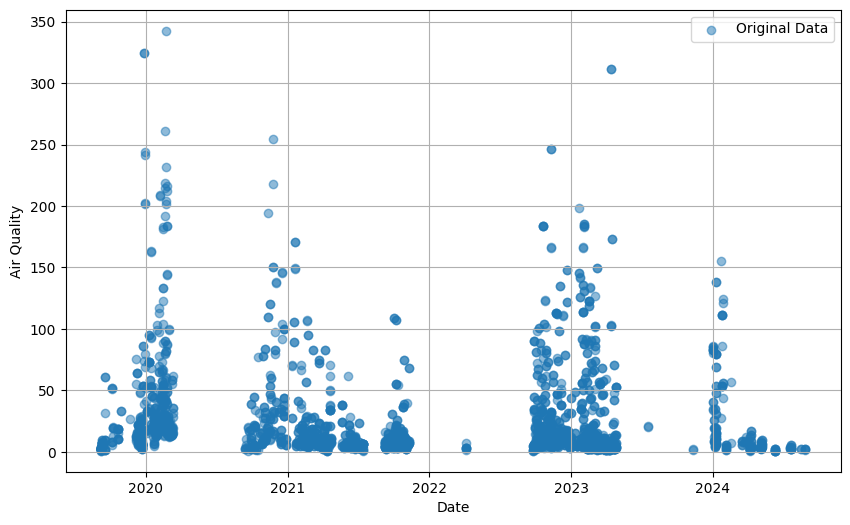

In [7]:
rolling_window = 5
rolling_mean = aq_timeseries['interpolated_air_quality'].iloc[0:30].rolling(window=rolling_window).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(aq_timeseries['timestamp']), aq_timeseries['interpolated_air_quality'], label='Original Data', alpha=0.5)
# plt.plot(pd.to_datetime(aq_timeseries['timestamp']).iloc[0:30], rolling_mean, color='red', label=f'{rolling_window}-Step Rolling Mean')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Air Quality')
plt.legend()
plt.show()

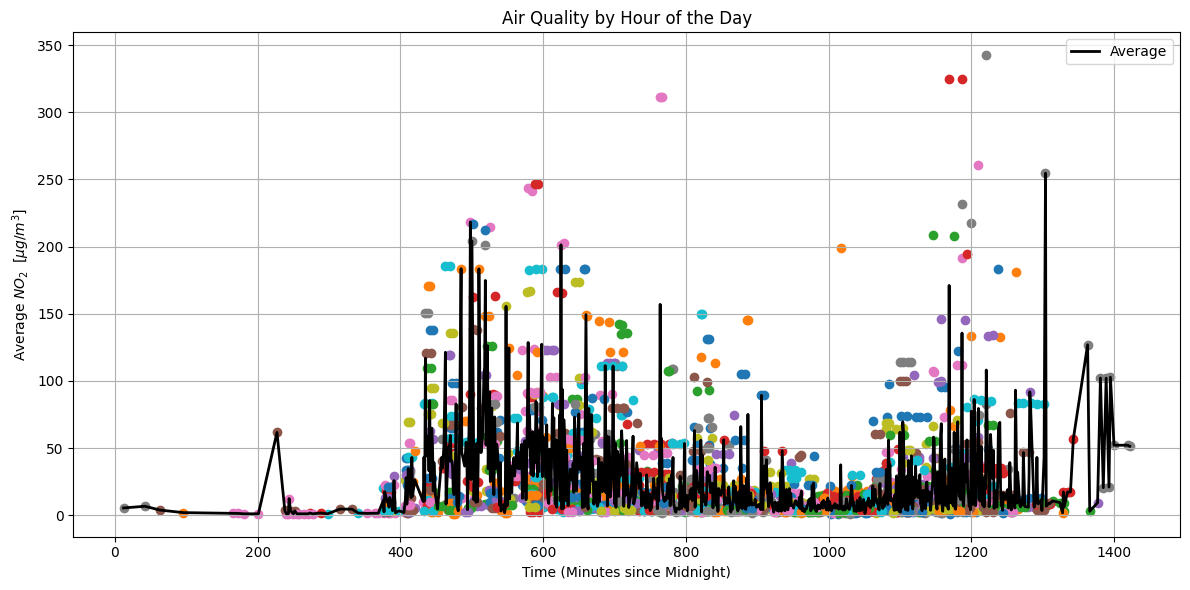

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

df = aq_timeseries
# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Extract time (hour:minute)
df["time"] = df["timestamp"].dt.time

# Convert time to number of minutes since midnight
df["time_minutes"] = df["timestamp"].dt.hour * 60 + df["timestamp"].dt.minute

# Debugging: Check DataFrame structure
# print("DataFrame after adding 'time_minutes':")
# print(df.head())

# Group by 'time' (hour-minute) and calculate mean air quality
mean_air_quality = df.groupby("time_minutes")["interpolated_air_quality"].mean()

# Plot all days
plt.figure(figsize=(12, 6))

# Loop through unique days and plot their respective data
for day, day_data in df.groupby(df["timestamp"].dt.date):
    # Debugging: Check group content
    # print(f"Day: {day}")
    # print(day_data.head())
    day_data = day_data.reset_index(drop=True)  # Reset index to ensure data integrity
    plt.scatter(day_data["time_minutes"], day_data["interpolated_air_quality"])

# rolling_window = 5
# rolling_mean = aq_timeseries['interpolated_air_quality'].iloc[0:30].rolling(window=rolling_window).mean()

rolling_window = 5
rolling_mean = mean_air_quality.rolling(window=rolling_window).mean()
# Overlay average line
plt.plot(mean_air_quality.index, mean_air_quality.values, label="Average", color="black", linewidth=2)
# plt.plot(mean_air_quality.index, rolling_mean, label = 'Rolling Mean')



# Customize plot
plt.title("Air Quality by Hour of the Day")
plt.xlabel("Time (Minutes since Midnight)")
plt.ylabel("Average $NO_{2}\;$ [$\mu g/m^{3}$]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
path_file = 'C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/air_quality_timeseries.csv'
aq_timeseries = pd.read_csv(path_file)
aq_timeseries = aq_timeseries.drop(columns = 'Unnamed: 0')

path_file = 'C:/Users/Ricardo/Desktop/ML in health/ML-Healthcare-Project/final_timeline.csv'

final_timeline = pd.read_csv(path_file)
final_timeline = final_timeline.drop(columns = 'Unnamed: 0')
final_timeline

,file_name,timestamp,latitude,longitude,address,normalized_weights,interpolated_air_quality
0,2019_DECEMBER.json,2019-12-05 22:57:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226...",9.272655
1,2019_DECEMBER.json,2019-12-06 10:46:00+00:00,40.322412,-3.759343,NaN,"{17: 0.4577910367190517, 56: 0.281384667144771...",12.461034
2,2019_DECEMBER.json,2019-12-06 11:20:00+00:00,40.340145,-3.733184,"Av. gran bretaña, s/n, 28916 Leganés, Madrid, ...","{17: 0.6001364674552794, 56: 0.216650450417137...",13.132736
3,2019_DECEMBER.json,2019-12-06 12:42:00+00:00,40.339210,-3.732560,NaN,"{17: 0.6042990166977114, 56: 0.214362856169662...",12.902006
4,2019_DECEMBER.json,2019-12-06 13:28:00+00:00,40.322226,-3.759255,"C. del Sufragio, 37, 28914 Leganés, Madrid, Es...","{17: 0.4579922552350765, 56: 0.281301807043226...",10.459637
...,...,...,...,...,...,...,...
2653,2024_MAY.json,2024-05-06 08:23:00+00:00,40.329774,-3.765725,NaN,"{17: 0.43774123417289823, 56: 0.28965192872749...",9.960708
2654,2024_MAY.json,2024-05-06 08:28:00+00:00,40.332437,-3.765110,"Av. de la Universidad, 30, 28911 Leganés, Madr...","{17: 0.43649637016467313, 56: 0.29027425768921...",9.958217
2655,2024_MAY.json,2024-05-06 10:59:00+00:00,40.329656,-3.765770,"C. Torrubia, 2, 28911 Leganés, Madrid, España","{17: 0.4377304053475789, 56: 0.289651802022588...",5.926563
2656,2024_MAY.json,2024-05-06 13:19:00+00:00,40.329890,-3.765792,NaN,"{17: 0.4374520790643491, 56: 0.289770790214414...",6.641924


c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: Futur

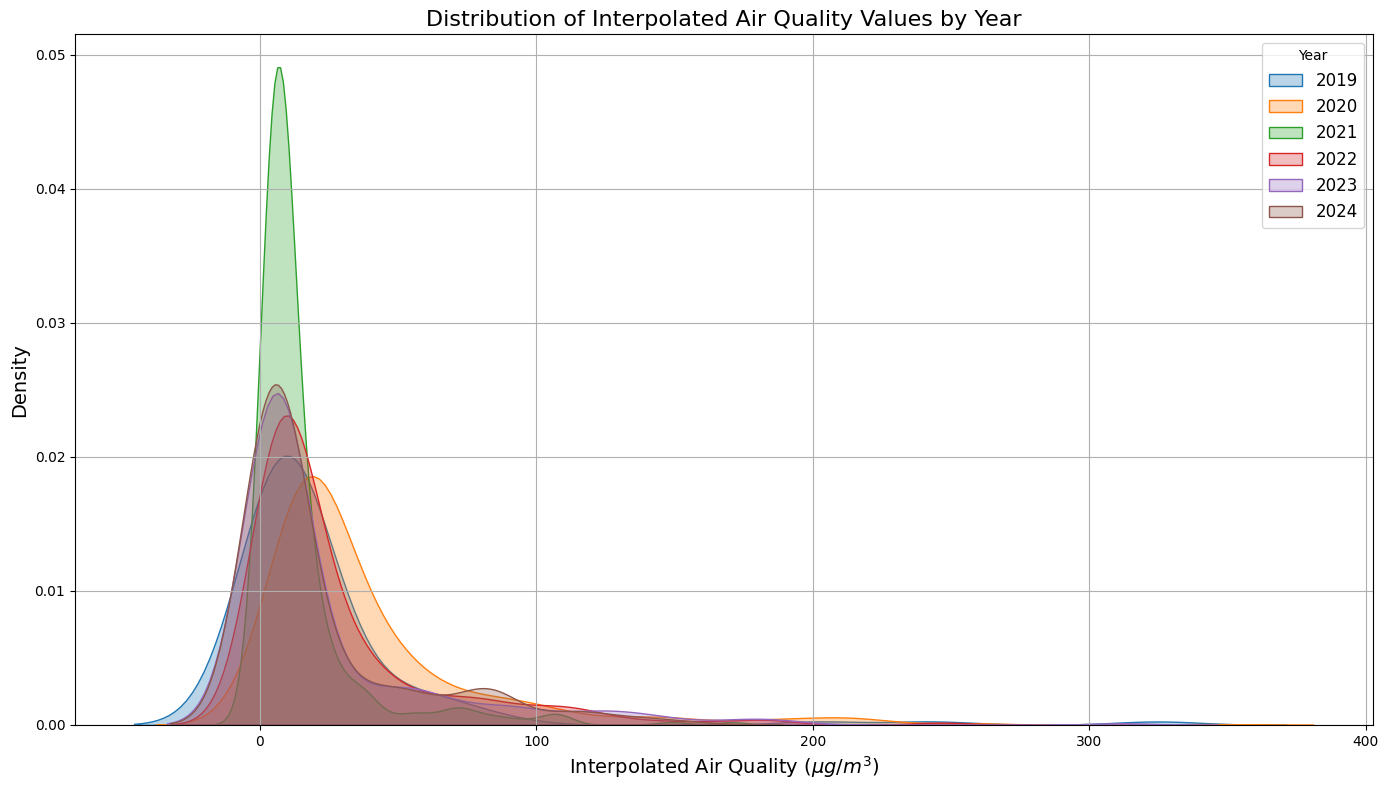

Summary Statistics by Year:
           mean     median        std       min         max
year                                                       
2019  23.030959  10.096794  45.057283  1.000000  324.736022
2020  39.695966  22.340589  45.291483  1.000000  342.536228
2021  14.504678   7.199762  21.300157  1.000000  170.538063
2022  27.699130  11.945064  37.294893  1.000000  246.665904
2023  24.829222   6.606866  41.664339  1.289644  311.600764
2024  21.596418   6.278865  32.248947  1.000000  155.548885


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'aq_timeseries' is your DataFrame
df = aq_timeseries.copy()

# Ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract year from timestamp
df['year'] = df['timestamp'].dt.year

# Plotting distributions for each year
plt.figure(figsize=(14, 8))

# Use seaborn to plot density (KDE) for each year
for year, year_data in df.groupby('year'):
    sns.kdeplot(year_data['interpolated_air_quality'], label=f"{year}", fill=True, alpha=0.3)

# Customize the plot
plt.title("Distribution of Interpolated Air Quality Values by Year", fontsize=16)
plt.xlabel("Interpolated Air Quality ($\mu g/m^{3}$)", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(title="Year", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Summarize statistics for each year
summary_stats = df.groupby('year')['interpolated_air_quality'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Summary Statistics by Year:")
print(summary_stats)


           mean        std      n   ci_lower   ci_upper
year                                                   
2019  23.030959  45.057283  206.0  16.878065  29.183854
2020  39.695966  45.291483  539.0  35.872386  43.519547
2021  14.504678  21.300157  682.0  12.906082  16.103274
2022  27.699130  37.294893  445.0  24.234016  31.164243
2023  24.829222  41.664339  585.0  21.452972  28.205473


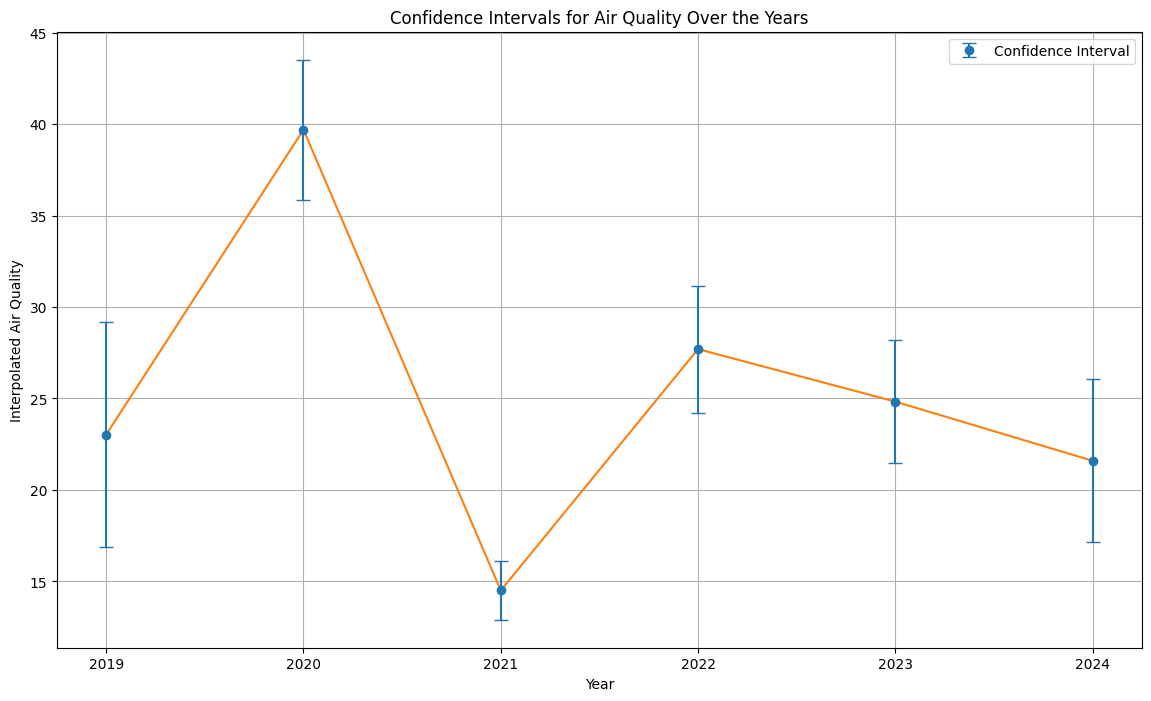

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming 'aq_timeseries' is your DataFrame
df = aq_timeseries.copy()

# Ensure timestamp is in datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract year from timestamp
df['year'] = df['timestamp'].dt.year

# Function to calculate confidence intervals
def calculate_ci(group, confidence=0.95):
    mean = group.mean()
    std = group.std()
    n = len(group)
    z = norm.ppf(1 - (1 - confidence) / 2)  # Z-score for the confidence level
    se = std / np.sqrt(n)  # Standard error
    ci_lower = mean - z * se
    ci_upper = mean + z * se
    return pd.Series({'mean': mean, 'std': std, 'n': n, 'ci_lower': ci_lower, 'ci_upper': ci_upper})

# Apply the function to each year
ci_stats = df.groupby('year')['interpolated_air_quality'].apply(calculate_ci)
 # Access the 'mean' for 2022

# Display the results
ci_stats_unstacked = ci_stats.unstack(level=1)



# Debugging: Check the new structure
print(ci_stats_unstacked.head())

# Plot with unstacked DataFrame
plt.figure(figsize=(14, 8))
plt.errorbar(
    ci_stats_unstacked.index,  # Years
    ci_stats_unstacked['mean'],  # Mean values
    yerr=[
        ci_stats_unstacked['mean'] - ci_stats_unstacked['ci_lower'], 
        ci_stats_unstacked['ci_upper'] - ci_stats_unstacked['mean']
    ], 
    fmt='o', capsize=5, label='Confidence Interval'
)
plt.title('Confidence Intervals for Air Quality Over the Years')
plt.xlabel('Year')
plt.plot(ci_stats_unstacked.index, ci_stats_unstacked['mean'])
plt.ylabel('Interpolated Air Quality')
plt.legend()
plt.grid(True)
plt.show()


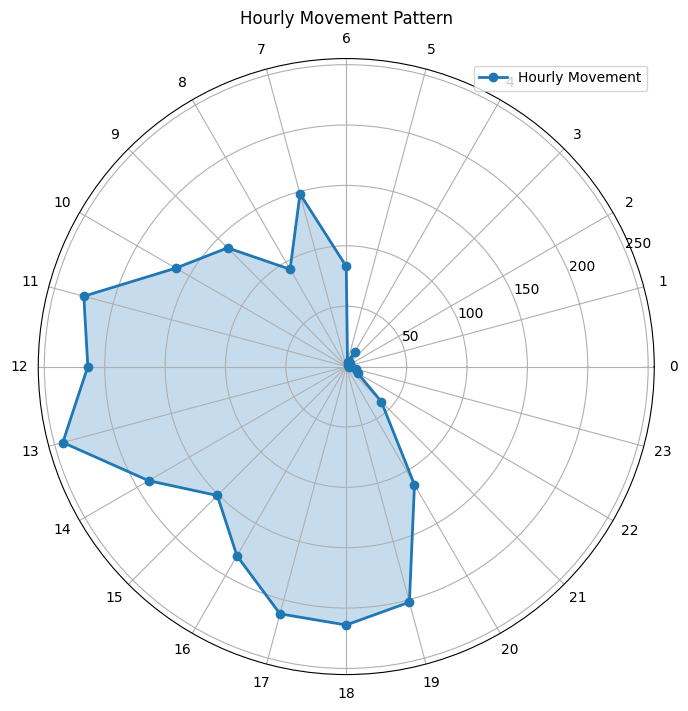

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Extract hour from timestamps
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# Count occurrences per hour
hour_counts = df['hour'].value_counts().sort_index()

# Create polar plot
angles = np.linspace(0, 2 * np.pi, len(hour_counts), endpoint=False).tolist()
counts = hour_counts.values

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": "polar"})
ax.plot(angles, counts, marker="o", linewidth=2, label="Hourly Movement")
ax.fill(angles, counts, alpha=0.25)
ax.set_xticks(angles)
ax.set_xticklabels(hour_counts.index)
ax.set_title("Hourly Movement Pattern")
ax.legend()
plt.show()


In [32]:
# Step 1: Aggregate H_Value by ESTACION (use max instead of mean)

data = aq_timeseries
station_data = info_estaciones

max_hvalue = data.groupby('ESTACION')['H_Value'].max().reset_index()
max_hvalue.rename(columns={'ESTACION': 'CODIGO_CORTO', 'H_Value': 'max_H_Value'}, inplace=True)

# Step 2: Merge with location data
merged_data = pd.merge(max_hvalue, station_data, on='CODIGO_CORTO')

# Step 3: Create Heatmap
map_center = [merged_data['LATITUD'].mean(), merged_data['LONGITUD'].mean()]
madrid_map = Map(location=map_center, zoom_start=11)

heatmap_data = merged_data[['LATITUD', 'LONGITUD', 'max_H_Value']].values.tolist()
HeatMap(heatmap_data, radius=10, max_zoom=13).add_to(madrid_map)

# Save map
madrid_map.save("station_max_hvalue_heatmap.html")
print("Heatmap saved as 'station_max_hvalue_heatmap.html'. Open it in your browser!")

Heatmap saved as 'station_max_hvalue_heatmap.html'. Open it in your browser!


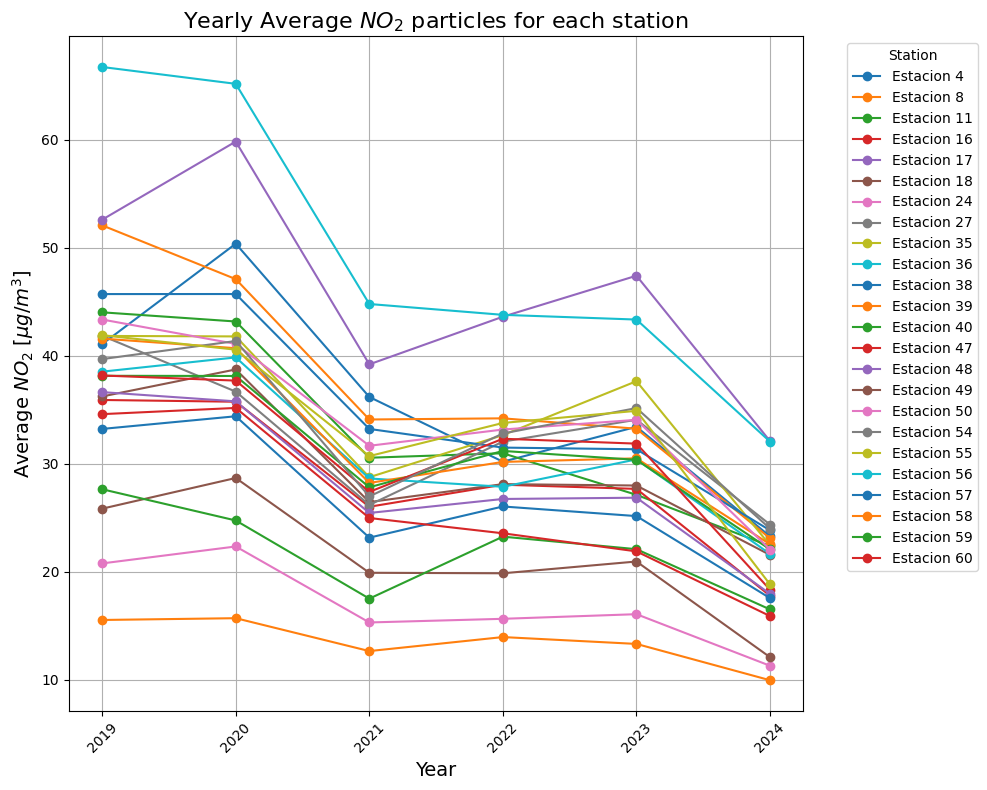

In [46]:
# Step 1: Extract Year from Timestamp
data['Year'] = data['Timestamp'].dt.year

# Step 2: Group by Year and ESTACION, calculate average
yearly_station_avg = data.groupby(['Year', 'ESTACION'])['H_Value'].mean().reset_index()

# Step 3: Pivot the data for plotting
pivot_data = yearly_station_avg.pivot(index='Year', columns='ESTACION', values='H_Value')

# Step 4: Plot the data
plt.figure(figsize=(10, 8))

for station in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[station], marker='o', linestyle='-', label=f'Estacion {station}')

plt.title('Yearly Average $NO_{2}$ particles for each station', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average $NO_{2}$ [$\mu g / m^{3}$]', fontsize=14)
plt.grid(True)
plt.xticks(pivot_data.index, rotation=45)
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.tight_layout()
plt.show()